# Creating a scalable and general workflow for simulation-based calibration of PyMC3 models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Any, Dict, List, Optional, Tuple

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = "retina"

gg.theme_set(gg.theme_bw)
sns.set_theme()
np.random.seed(1234)

## Simulation-based calibration steps

1. Draws parameters from the prior
2. Simulate data from the sampled parameters
3. Fit the model to the simulated data
4. Compare the posterior parameter estimates to the actual values

## "True" mock data

This data set represents the "true" data that the model will eventually be fit with.
This is necessary because I mainly fit hierarchical models meaning I need to know the number of varying intercepts during model construction.

In [3]:
from string import ascii_uppercase

N_GROUPS = 5
N_DATA_POINTS = 10

groups = list(ascii_uppercase[:N_GROUPS])

real_params: Dict[str, Any] = dict(
    α=np.random.normal(0, 5, N_GROUPS), β=np.random.normal(0, 1, N_GROUPS), σ=0.5
)

x = np.random.normal(0, 1, N_GROUPS * N_DATA_POINTS)
data = pd.DataFrame(dict(x=x, group=np.repeat(groups, N_DATA_POINTS)))
data["group"] = pd.Categorical(data["group"], categories=groups, ordered=True)

idx = data["group"].cat.codes.to_numpy()

data["y"] = (
    real_params["α"][idx]
    + real_params["β"][idx] * x
    + np.abs(np.random.normal(0, real_params["σ"], len(x)))
)
data.head()

,x,group,y
0,1.150036,A,3.864563
1,0.991946,A,3.272366
2,0.953324,A,3.356914
3,-2.021255,A,0.668243
4,-0.334077,A,2.577695


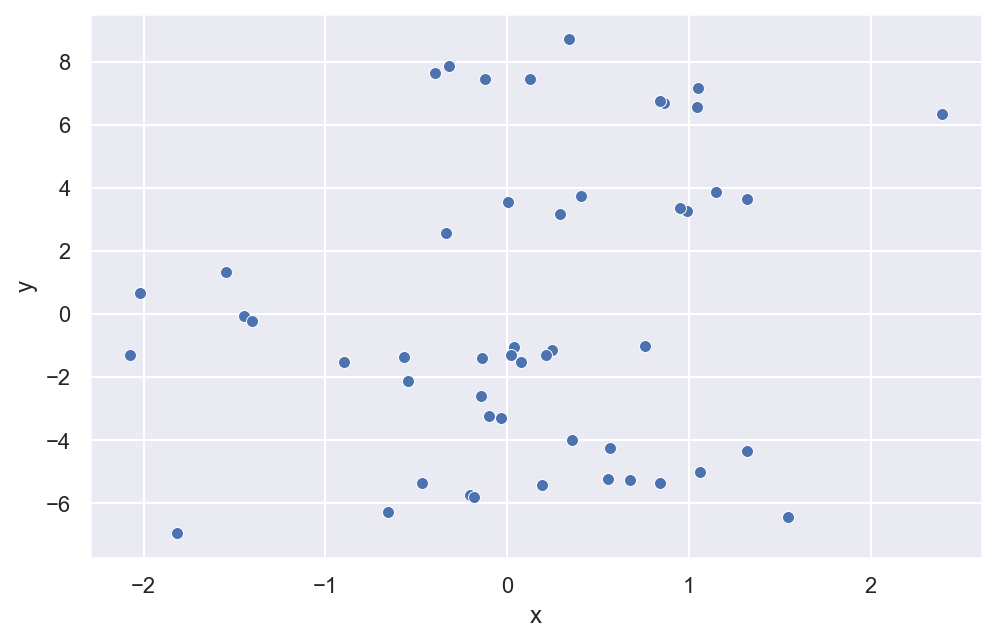

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(x="x", y="y", data=data, ax=ax);

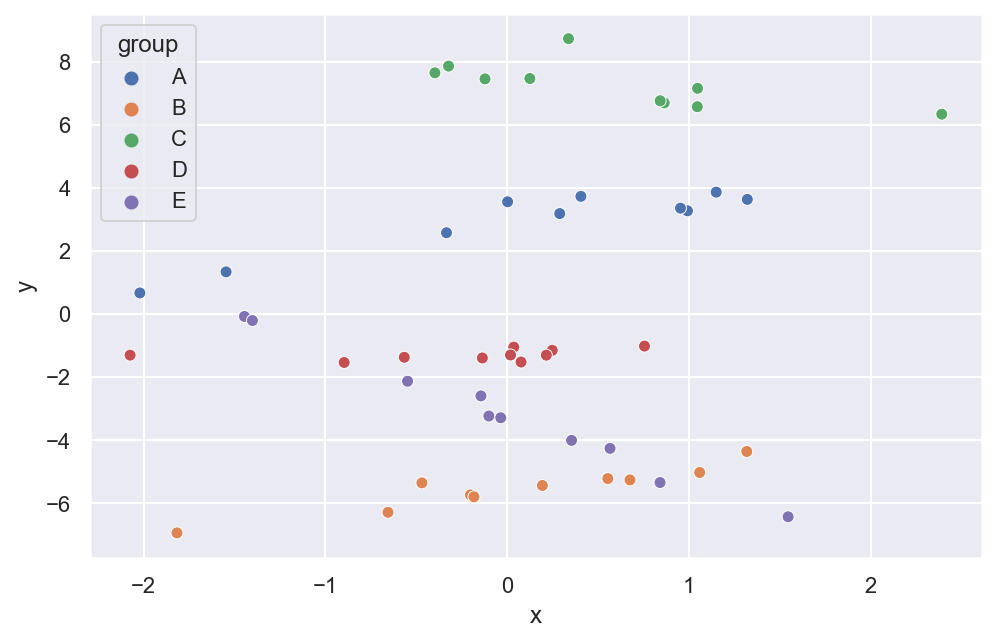

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(x="x", y="y", hue="group", data=data);

## Model

In [6]:
group_idx = data["group"].cat.codes.to_numpy()


def build_model(x_values: np.ndarray, y_values: np.ndarray, n_groups: int) -> pm.Model:
    with pm.Model() as model:
        μ_α = pm.Normal("μ_α", 0, 2)
        σ_α = pm.HalfNormal("σ_α", 2)
        μ_β = pm.Normal("μ_β", 0, 1)
        σ_β = pm.HalfNormal("σ_β", 1)

        α = pm.Normal("α", μ_α, σ_α, shape=n_groups)
        β = pm.Normal("β", μ_β, σ_β, shape=n_groups)

        μ = pm.Deterministic("μ", α[group_idx] + β[group_idx] * x_values)
        σ = pm.HalfNormal("σ", 2)

        y = pm.Normal("y", μ, σ, observed=y_values)
    return model

In [7]:
model = build_model(data.x.values, data.y.values, n_groups=N_GROUPS)

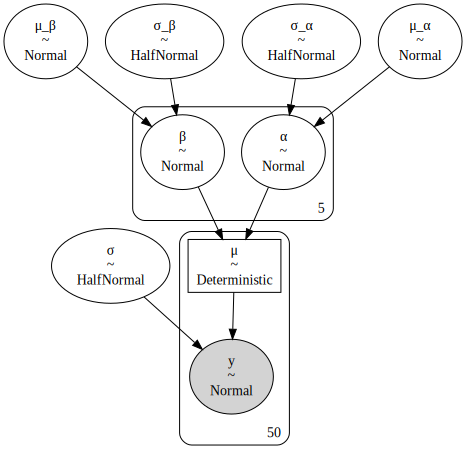

In [8]:
pm.model_to_graphviz(model)

In [9]:
with model:
    prior_sample = pm.sample_prior_predictive(1, random_seed=0)

In [10]:
prior_sample.keys()

dict_keys(['σ', 'α', 'σ_α_log__', 'σ_log__', 'σ_β', 'β', 'μ_β', 'μ', 'σ_α', 'σ_β_log__', 'y', 'μ_α'])

In [11]:
prior_sample.get("μ_α"), prior_sample.get("σ_α")

(array([3.52810469]), array([0.80031442]))

In [12]:
prior_sample.get("μ_β"), prior_sample.get("σ_β")

(array([-0.15135721]), array([0.10321885]))

In [13]:
prior_sample.get("μ").flatten()

array([4.18607686, 4.2033048 , 4.20751364, 4.53167047, 4.34780913,
       4.31117196, 4.26721824, 4.27989881, 4.16742867, 4.47997793,
       5.34918286, 5.41105655, 5.2951239 , 5.24598539, 5.14161038,
       5.38557893, 5.22931799, 5.56952841, 5.34651616, 5.17698597,
       5.02323509, 5.02231689, 5.02143009, 5.02143214, 5.02165969,
       5.02289074, 5.02258254, 5.02314137, 5.02168722, 5.01975252,
       2.7404275 , 2.78721451, 2.74334385, 2.8970413 , 2.72793491,
       2.81129151, 2.75593429, 2.74464359, 2.69097813, 2.73030275,
       4.17174377, 4.48914977, 4.48306531, 4.3024814 , 4.36456913,
       4.30854706, 4.23933682, 4.29340329, 4.20995077, 4.07393972])

In [14]:
mock_y = prior_sample.get("y").flatten()

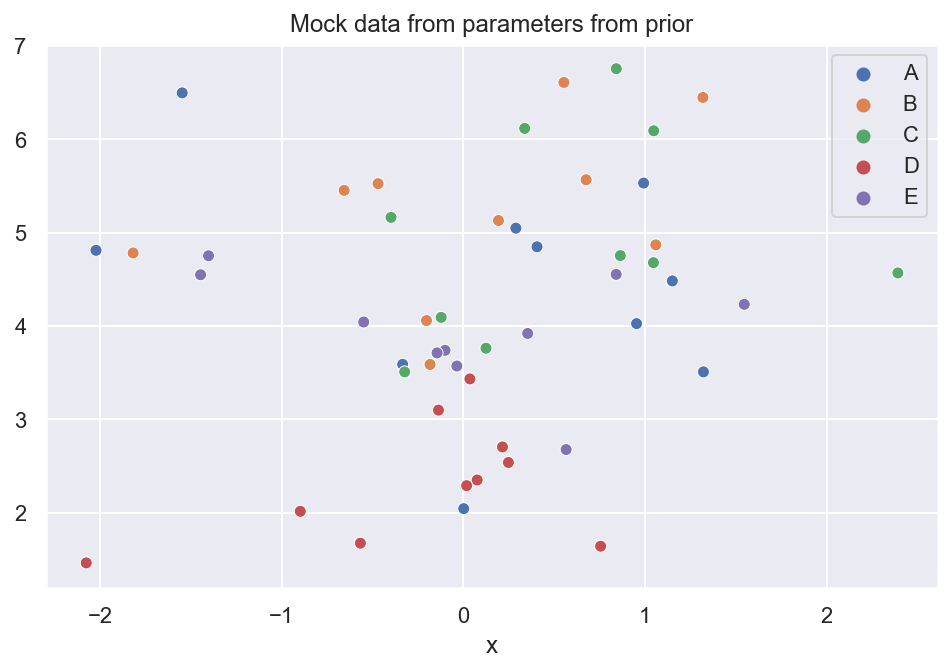

In [15]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.scatterplot(x=data.x, y=mock_y, hue=data.group.values, ax=ax)
ax.set_title("Mock data from parameters from prior");

In [16]:
mock_model = build_model(x_values=data.x.values, y_values=mock_y, n_groups=N_GROUPS)
with mock_model:
    trace = pm.sample(
        1000, tune=2000, chains=3, cores=3, random_seed=321, target_accept=0.95
    )
    posterior_pred = pm.sample_posterior_predictive(trace, 1000, random_seed=321)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [σ, β, α, σ_β, μ_β, σ_α, μ_α]


Sampling 3 chains for 2_000 tune and 1_000 draw iterations (6_000 + 3_000 draws total) took 61 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample


In [17]:
mock_az = az.from_pymc3(trace=trace, posterior_predictive=posterior_pred)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


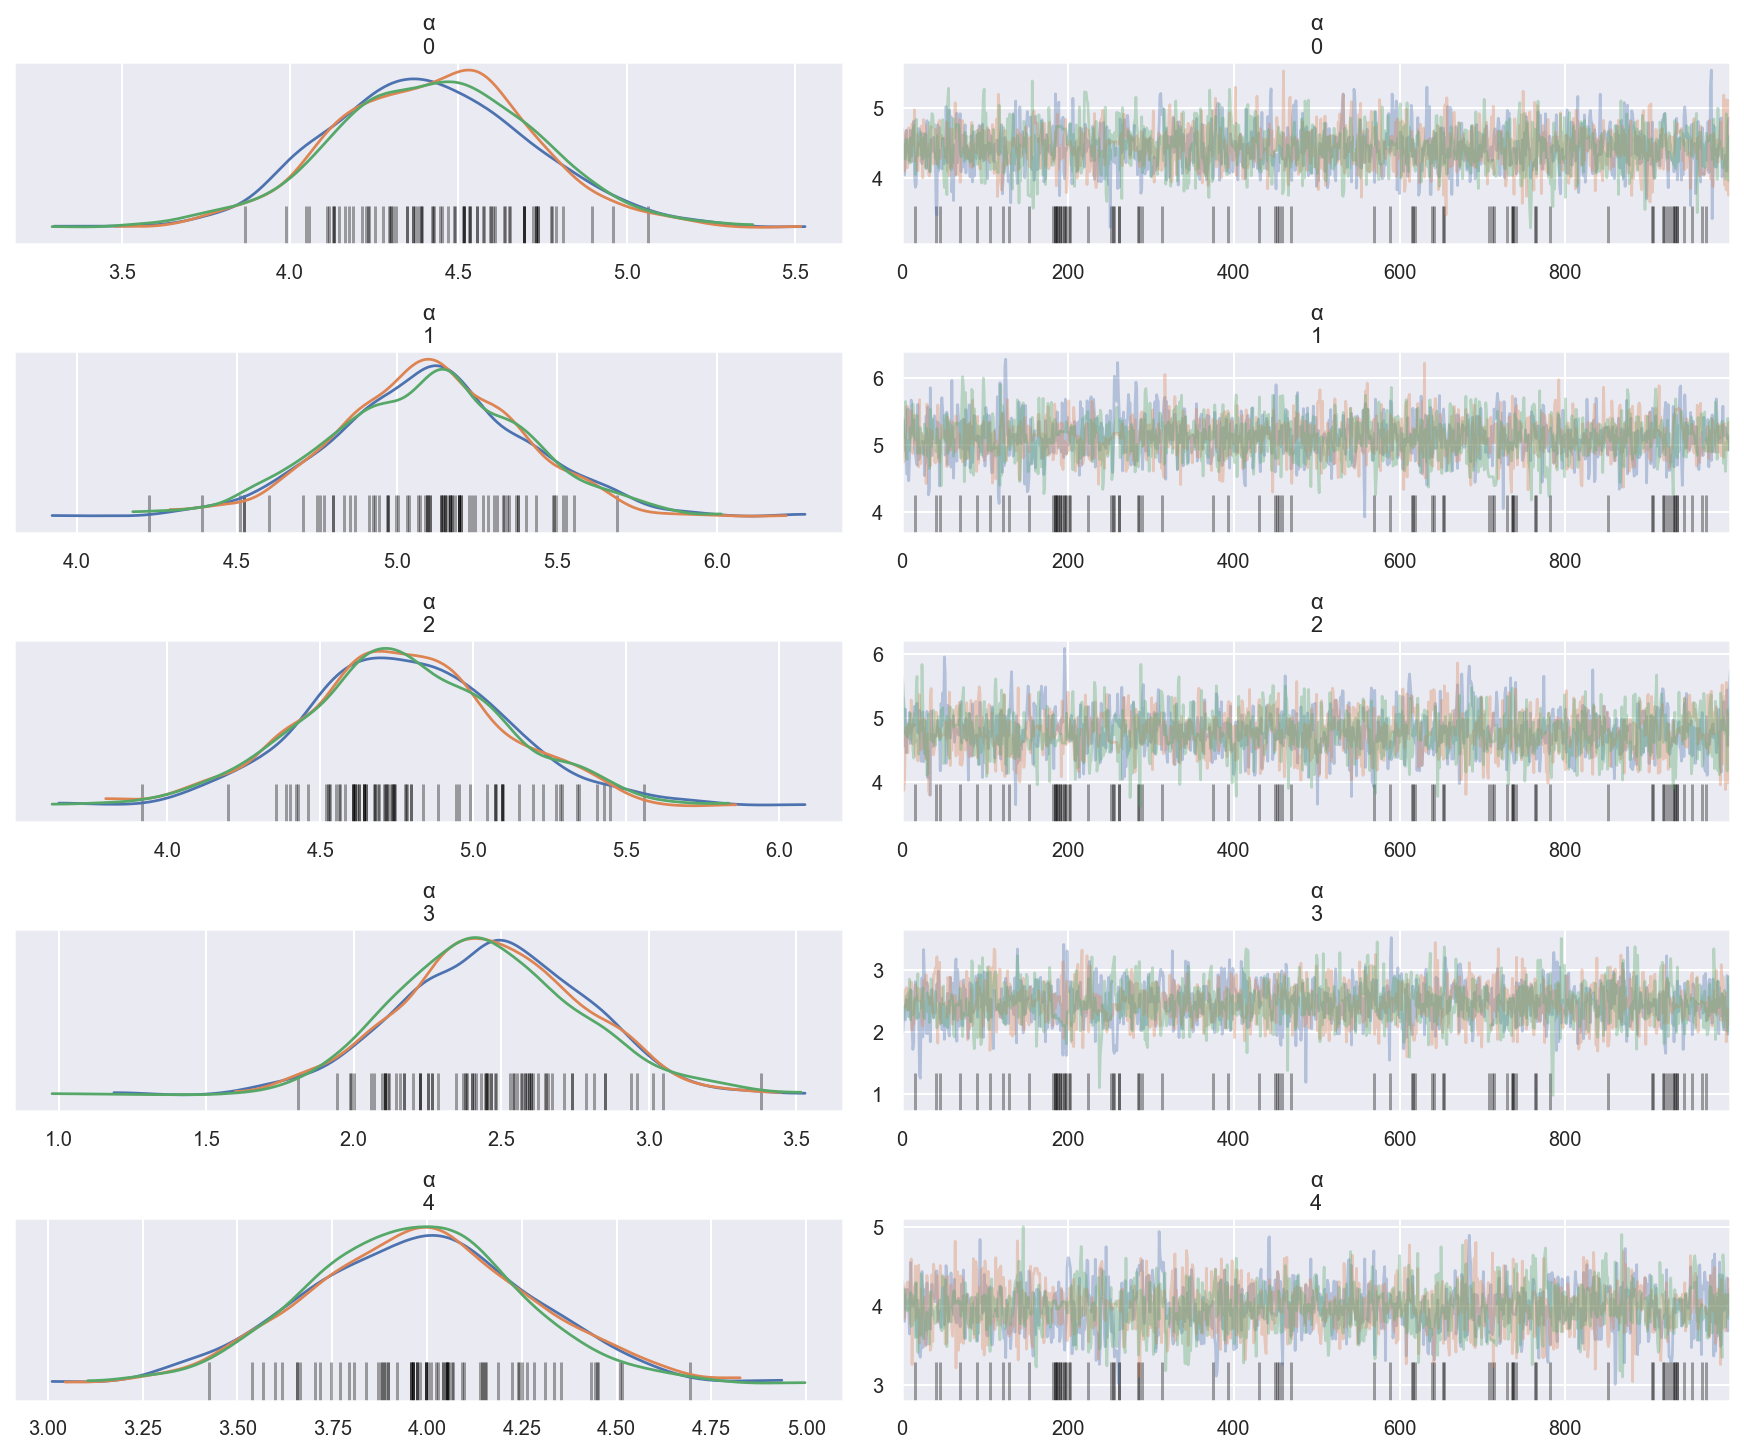

In [18]:
az.plot_trace(mock_az, var_names=("α"), compact=False);

In [19]:
df = az.summary(mock_az, var_names="α", kind="stats")
df["real"] = prior_sample.get("α").flatten()
df

,mean,sd,hdi_3%,hdi_97%,real
α[0],4.422,0.299,3.841,4.967,4.311403
α[1],5.102,0.298,4.570,5.692,5.321524
α[2],4.767,0.330,4.152,5.406,5.022738
α[3],2.465,0.317,1.908,3.085,2.745975
α[4],3.971,0.291,3.415,4.515,4.288474


---

In [20]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-03-30

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : Clang 11.0.1 
OS          : Darwin
Release     : 20.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: simulation-based-calibration

numpy     : 1.20.1
matplotlib: 3.3.4
arviz     : 0.11.2
pymc3     : 3.11.1
plotnine  : 0.7.1
pandas    : 1.2.3
seaborn   : 0.11.1

